<!-- Banner Image -->
<img src="https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdevnotebooks.png" width="100%">

<!-- Links -->
<center>
  <a href="https://console.brev.dev" style="color: #06b6d4;">Console</a> •
  <a href="https://brev.dev" style="color: #06b6d4;">Docs</a> •
  <a href="/" style="color: #06b6d4;">Templates</a> •
  <a href="https://discord.gg/NVDyv7TUgJ" style="color: #06b6d4;">Discord</a>
</center>


# How to Deploy your Model on Replicate for Inference

## In this guide, we'll upload our model checkpoint to Replicate for deployment and inference. 

## Watch the accompanying video walk-through [here](https://www.youtube.com/watch?v=eczHFcqx1ic)!

### There are five stages to this process:
1. Save your Model Checkpoint
2. Install Docker
3. Install & Initiate Cog
4. Set Up Cog Requirements
    1. cog.yaml
    2. predict.py
5. Create Replicate Model & Push

#### Help make this tutorial better! If you encounter any issues, please reach out to me on [**X**](https://x.com/harperscarroll) or on [**Discord**](https://discord.gg/NVDyv7TUgJ).


## 1. Save your Model Checkpoint

To get started, locate your `checkpoint-[STEP#]` directory created when fine-tuning your model. It should look something like this.

If you still need to train a model to get this checkpoint directory, you can follow [this guide](https://github.com/brevdev/notebooks/blob/main/mistral-finetune-own-data.ipynb) or [this guide](https://github.com/brevdev/notebooks/blob/main/mistral-finetune.ipynb&python=3.10&cuda=12.1.1).

Once you've checked out your machine and landed in your instance page, select the specs you'd like  (I used **Python 3.10 and CUDA 12.1.1**; these should be preconfigured for you if you use the badge above) and click the "Build" button to build your verb container. Give this a few minutes.

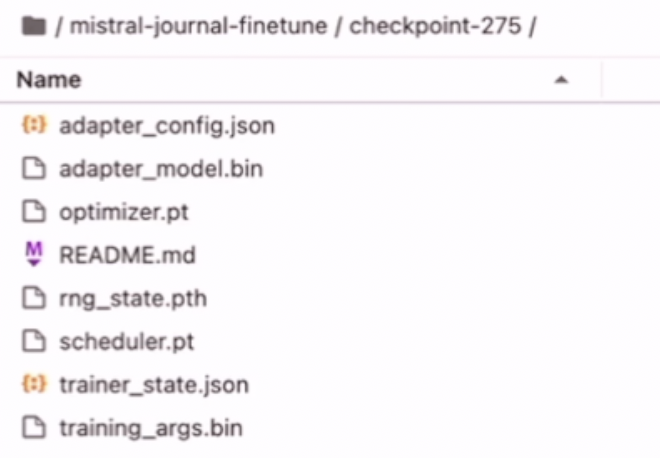


If you already have the checkpoint downloaded and need a new GPU, click the badge below to get your preconfigured instance:

[![](https://brev-assets.s3.us-west-1.amazonaws.com/nv-lb-dark.svg)](https://console.brev.dev/environment/new?instance=A10G:g5.xlarge&diskStorage=256&name=deploy-to-replicate&file=https://github.com/brevdev/notebooks/raw/main/deploy-to-replicate.ipynb)


Now, either copy the checkpoint directory to the same directory where this notebook is located, or update the path below to point to where the checkpoint exists on this machine.

In [1]:
checkpoint_dir = "."

## Install Docker if not installed

First, let's check if Docker is installed, and if not, let's install it.

In [7]:
%%writefile install_docker.sh
#!/bin/bash

# Function to check if a command exists
command_exists() {
  command -v "$@" > /dev/null 2>&1
}

# Check if Docker is already installed
if command_exists docker; then
  echo "Docker is already installed. Checking the version..."
  sudo docker --version
else
  echo "Docker is not installed. Proceeding with the installation..."

  echo 'Step 1: Update Software Repositories'
  sudo apt update

  echo 'Step 2: Install Dependencies'
  sudo apt install -y apt-transport-https ca-certificates curl software-properties-common

  echo 'Step 3: Add Docker’s GPG Key'
  curl -fsSL https://download.docker.com/linux/ubuntu/gpg | sudo apt-key add -

  echo 'Step 4: Add Docker Repository'
  sudo add-apt-repository -y "deb [arch=amd64] https://download.docker.com/linux/ubuntu $(lsb_release -cs) stable"

  echo 'Step 5: Update Package Database'
  sudo apt update

  echo 'Step 6: Install Docker CE'
  sudo apt install -y docker-ce

  echo 'Step 7: Start and Enable Docker'
  sudo systemctl start docker
  sudo systemctl enable docker

  echo "Docker has been installed successfully."
  sudo docker --version
fi

Overwriting install_docker.sh


In [8]:
!chmod +x install_docker.sh && ./install_docker.sh

Docker is not installed. Proceeding with the installation...
Step 1: Update Software Repositories
Hit:1 https://download.docker.com/linux/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease              
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease    
0% [Waiting for headers] [Waiting for headers]                  

Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
48 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://download.docker.com/linux/ubuntu/dists/jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
Step 2: Install Dependencies
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ca-certificates is already the newest version (20230311ubuntu0.22.04.1).
curl is already the newest version (7.81.0-1ubuntu1.14).
software-properties-common is already the newest version (0.99.22.7).
apt-transport-https is already the newest version (2.4.10).
0 upgraded, 0 newly installed, 0 to r

## 3. Install & Initiate Cog

Next, let's install Cog via the code provided by [Replicate](https://replicate.com/docs/guides/push-a-model).

In [7]:
!sudo curl -o /usr/local/bin/cog -L https://github.com/replicate/cog/releases/latest/download/cog_`uname -s`_`uname -m`
!sudo chmod +x /usr/local/bin/cog

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 9792k  100 9792k    0     0  8730k      0  0:00:01  0:00:01 --:--:-- 8730k


In [8]:
!cd {checkpoint_dir}
!cog init


Setting up the current directory for use with Cog...

✅ Created /home/ubuntu/verb-workspace/cog.yaml
✅ Created /home/ubuntu/verb-workspace/predict.py
✅ Created /home/ubuntu/verb-workspace/.dockerignore

Done! For next steps, check out the docs at https://cog.run/docs/getting-started


Great! Everything should have been Created! 

## 4. Set Up Cog Requirements

I define the Cog requirements as follows. Feel free to edit them to adapt to your specific model requirements. 

### cog.yaml & requirements.txt:

In [ ]:
%%writefile cog.yaml
build:
  gpu: true
  cuda: "12.0.1"
  python_version: "3.10"
  python_requirements: requirements.txt
predict: "predict.py:Predictor"

In [ ]:
%%writefile requirements.txt
bitsandbytes
git+https://github.com/huggingface/transformers.git
git+https://github.com/huggingface/peft.git
git+https://github.com/huggingface/accelerate.git
scipy

### predict.py:
This defines how the model is initialized and how it runs when called.

In [ ]:
%%writefile predict.py
# Prediction interface for Cog ⚙️
# https://github.com/replicate/cog/blob/main/docs/python.md

import torch
from cog import BasePredictor, Path, Input
from peft import PeftModel
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

DEFAULT_PROMPT = "The following in a note by Eevee the Dog that doesn\'t share anything too personal: # "

class Predictor(BasePredictor):
    def setup(self) -> None:
        "Load the model into memory to make running multiple predictions efficient"
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        base_model_id = "mistralai/Mistral-7B-v0.1"

        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16
        )

        base_model = AutoModelForCausalLM.from_pretrained(
            base_model_id,  # Mistral, same as before
            quantization_config=bnb_config,  # Same quantization config as before
            device_map="auto",
            trust_remote_code=True,
        )
        
        self.tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
        self.model = PeftModel.from_pretrained(base_model, ".")
        self.model.to(self.device)

    def predict(
        self,
        prompt: str = Input(description="Prompt for the model", default=DEFAULT_PROMPT),
        max_new_tokens: int = Input(description="Number of tokens to generate", default=100)
    ) -> Path:
        "Run a single prediction on the model"
        self.model.eval()
        with torch.no_grad():
            model_input = self.tokenizer(prompt, return_tensors="pt").to("cuda")
            return(self.tokenizer.decode(self.model.generate(**model_input, max_new_tokens=max_new_tokens)[0], skip_special_tokens=True))

Now let's replace the base files with our defined files. 

## 5. Create Replicate Model & Push
Now, go to [Replicate's create model page](https://replicate.com/create) and create a model, setting the kind of model to "Custom Cog Model".

**Then, replace <your-username> and <your-model-name> in the code below with your username and your model name.** Then, open a Terminal (via `Launcher` or `+` --> Terminal) and paste the command.

```bash
sudo cog login && sudo cog push r8.im/<your-username>/<your-model-name>
```

Follow the instructions provided in the shell (i.e. as of this writing, hit Enter, then paste the auth token from https://replicate.com/auth/token).

Then, a script should run for a while as everything is uploaded! 

When the script has completed, head over to your model's page (`https://replicate.com/<your-username>/<your-model-name>`) to view your uploaded model! It should look similar to this:

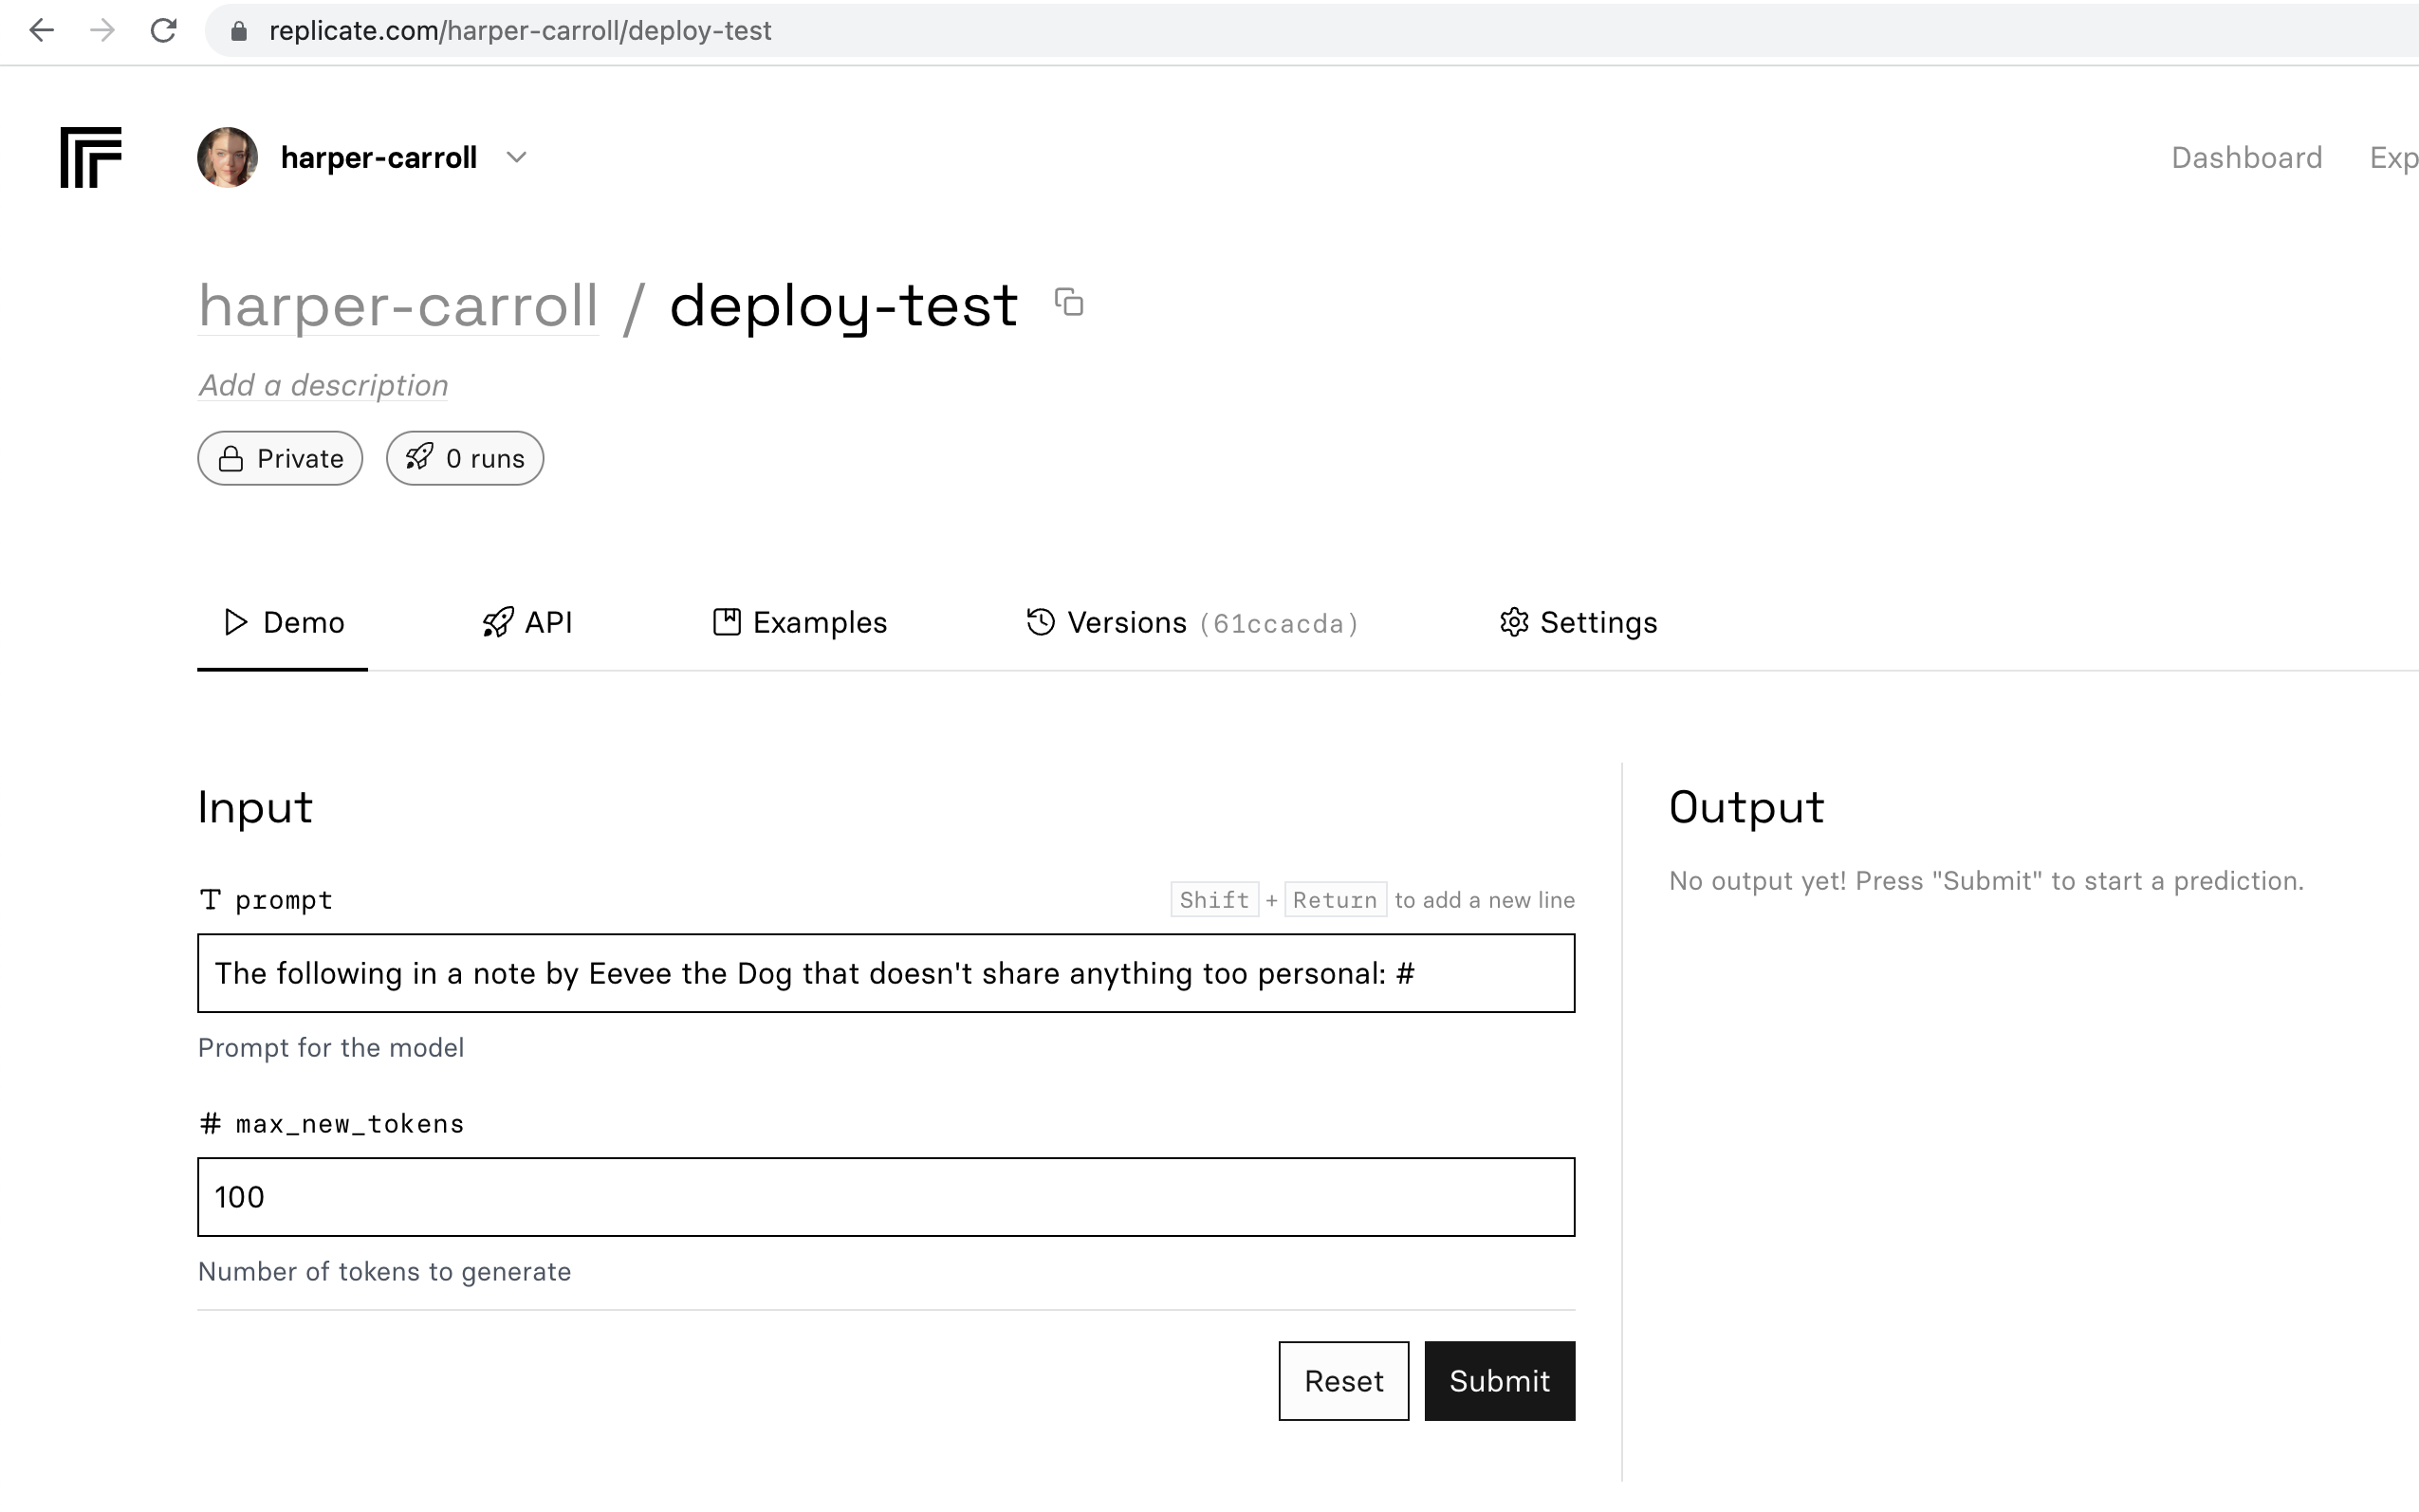

### You can click the "API" tab to get APIs in various languages that you can use to call your model for inference in production! 
If you need a programming language that's not listed, try asking ChatGPT to translate for you!


## There you go! I hope this was helpful!
### Remember to please help make this tutorial better! If you encounter any issues, please reach out to me on [**X**](https://x.com/harperscarroll) or on [**Discord**](https://discord.gg/NVDyv7TUgJ).
